# Segmentation and clustering of largest counties in historically red and blue states

In [89]:
import matplotlib.pyplot as plt
import geopandas
import numpy as np
import pandas as pd
from tqdm import tqdm #progress bar in for loops
import geocoder
import requests

### 1. Read all the necessary files

In [90]:
# Read files that give us the shape of all US counties
shape_file = geopandas.read_file('./geo_files/cb_2018_us_county_500k.shp')
# Read census files for population information 
url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv"
census_file = pd.read_csv(url, encoding = "ISO-8859-1")

For both shape and census data let's look at only Texas and California. In order to do this we need state FP numbers which are 06 for California and 48 for Texas. 

In [91]:
# FP codes for the states
# California	CA	06
# Texas         TX  48
print (shape_file['STATEFP'].dtype)
print (census_file['STATE'].dtype)

object
int64


In [92]:
shape_file['STATEFP'] = shape_file['STATEFP'].astype(int)

In [93]:
cal_shape = shape_file[shape_file['STATEFP']==6].reset_index(drop=True)
tex_shape = shape_file[shape_file['STATEFP']==48].reset_index(drop=True)

cal_census = census_file[census_file['STATE']==6].reset_index(drop=True)
tex_census = census_file[census_file['STATE']==48].reset_index(drop=True)

In [94]:
def df_shapes():
    
    print (cal_shape.shape)
    print (cal_census.shape)
    
    print (tex_shape.shape)
    print (tex_census.shape)
    return

#### We see that the census entries have one more row. Lets see what it is and remove it if not necessary

In [95]:
# print ('California: \n{}\n{}\n{}'.format(100*'.',cal_census.loc[0,'CTYNAME'],100*'-'))
# print ('')
# print ('Texas: \n{}\n{}\n{}'.format(100*'.',tex_census.loc[0,'CTYNAME'],100*'-'))

#### We have information about the state in addition to counties in the census files. Lets remove the 0th entry in the census files

In [96]:
cal_census = cal_census.drop([0])
tex_census = tex_census.drop([0])

cal_census.reset_index(drop=True, inplace=True)
tex_census.reset_index(drop=True, inplace=True)

#### Let's check the shapes again

In [97]:
print (cal_shape.shape)
print (cal_census.shape)
    
print (tex_shape.shape)
print (tex_census.shape)

(58, 10)
(58, 164)
(254, 10)
(254, 164)


#### Now that they are the same size let's add the shape data to the census data. In other words let's merge the two datasets. In order to merge the two data sets for each of California and Texas on the county name column we first rename the county name column on shape data

In [98]:
tex_shape.rename(columns={'NAME':'CTYNAME'}, inplace=True)
cal_shape.rename(columns={'NAME':'CTYNAME'}, inplace=True)

In [99]:
# print (tex_shape.columns)
# print (tex_census.columns)

#### There is a small problem. The county names for on census and shape files don't match. The word 'County' is added to the county names in the census files

In [100]:
# print ('Census: \n{}\n{}\n{}'.format(100*'.',tex_census['CTYNAME'],100*'-',))
# print ('Shape file: \n{}\n{}\n{}'.format(100*'.',tex_shape['CTYNAME'],100*'-',))

#### Let's remove the extra word from the data. Note that strip function doesn't work properly for removing 'County'. Instead we use split and join to remove the last word

In [101]:
tex_census['CTYNAME'] = tex_census['CTYNAME'].map(lambda x: ' '.join(x.split()[:-1])) #the labmda function here gets rid of County at the end
cal_census['CTYNAME'] = cal_census['CTYNAME'].map(lambda x: ' '.join(x.split()[:-1])) #the labmda function here gets rid of County at the end

In [102]:
# print ('CALIFORNIA: \n{}\n{}'.format(100*':',100*':'))
# print ('Census: \n{}\n{}\n{}'.format(100*'.',cal_census['CTYNAME'],100*'-',))
# print ('Shape file: \n{}\n{}\n{}'.format(100*'.',cal_shape['CTYNAME'],100*'-',))
# print ('TEXAS: \n{}\n{}'.format(100*':',100*':'))
# print ('Census: \n{}\n{}\n{}'.format(100*'.',tex_census['CTYNAME'],100*'-',))
# print ('Shape file: \n{}\n{}\n{}'.format(100*'.',tex_shape['CTYNAME'],100*'-',))

#### Now the different data frames seem to have the same number of rows. Next lets try to merge the Data frames for eith of states Texas and California

In [103]:
tex_merged = tex_census.merge(tex_shape, on="CTYNAME", how="inner")
cal_merged = cal_census.merge(cal_shape, on="CTYNAME", how="inner")

In [104]:
print (tex_merged.shape)
print (cal_merged.shape)

(254, 173)
(58, 173)


In [105]:
y=['0CTYNAME', 'CTYNAME', '2CTYNAME', 'CTYNAME']
x=['CTYNAME']

set(y)-set(x)

{'0CTYNAME', '2CTYNAME'}

#### Now let's remove the extra data that we don't need in the analysis

In [106]:
def exclude_columns(extra_years, census_file):
    exclude_list = []
    for i in extra_years:
        exclude_list+=list(census_file.filter(regex=i))
    return exclude_list

In [107]:
extra_years = ['2010','2011','2012','2013', '2014', '2015', '2016', '2017','2018']
list_2019 = list(set(list(census_file)) - set(exclude_columns(extra_years, census_file)))

tex_merged = tex_merged[list_2019+list(tex_shape.columns.values[tex_shape.columns.values!='CTYNAME'])] 
cal_merged = cal_merged[list_2019+list(cal_shape.columns.values[cal_shape.columns.values!='CTYNAME'])] 

In [108]:
# print (tex_merged.columns)
# print (cal_merged.columns)
# tex_merged['CTYNAME']

#### Let's add the center points to each data frame

In [109]:
import geopandas as gpd

tex_merged = gpd.GeoDataFrame(tex_merged)
cal_merged = gpd.GeoDataFrame(cal_merged)

tex_centroid = tex_merged.geometry.centroid
cal_centroid = cal_merged.geometry.centroid

### 2. Exploratory analysis of the census and election data

#### Lets plot the shape files for two states that have historically been either blue or red

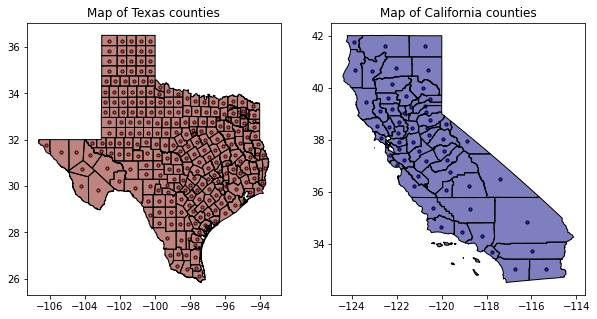

In [22]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

#texas
# ax[0].set_aspect(1)
tex_centroid.plot(ax = ax[0], fc=(0.5,0.5,0.5,0.6), ec=(0,0,0,1), markersize=10)
tex_merged.plot(ax = ax[0], color=(0.4863,0.039,0.00784,0.5))
tex_merged.boundary.plot( ax = ax[0], color='Black', linewidth = 1)
# tex_merged.plot( alpha=0.1, ax = ax, color='Grey', linewidth = 1)
ax[0].set_ylim()
ax[0].set_title('Map of Texas counties')

#calif
# ax[1].set_aspect(1)
cal_centroid.plot(ax = ax[1], fc=(0.,0.,0.5,0.6), ec=(0,0,0,1), markersize=10)
cal_merged.plot(ax = ax[1], color=(0.,0.,0.5,0.5))
cal_merged.boundary.plot( ax = ax[1], color='Black', linewidth = 1)
ax[1].set_title('Map of California counties')


plt.show()

In [110]:
import os
import sys
print (os.getcwd())
current_files = os.listdir(os.getcwd())

/Users/sayebms1/my_github/coursera/IBM_data_science/capstone


In [111]:
def get_latlng(county_list, state):
    current_files = os.listdir(os.getcwd())
    
    if state=='California':
        print ('CA files are loading' if 'ca_latlng_vals.npy' in current_files else 'creating files')
    if state =='Texas':
        print ('TX files are loading' if 'tx_latlng_vals.npy' in current_files else 'creating files')
    if 'ca_latlng_vals.npy' in current_files:
        return np.load('ca_latlng_vals.npy')
    if 'tx_latlng_vals.npy' in current_files:
        return np.load('tx_latlng_vals.npy')
    latlng = []
    for i in tqdm(range(len(county_list))):
        g=geocoder.arcgis('{}, {}'.format(county_list[i], state))
        latlng.append(g.latlng)
    return latlng
    

In [112]:
tx_latlng_vals = get_latlng(tex_merged['CTYNAME'], 'Texas')
ca_latlng_vals = get_latlng(cal_merged['CTYNAME'], 'California')

TX files are loading
CA files are loading


In [113]:
cal_merged['CTYNAME'] = cal_merged['CTYNAME'].apply(lambda x: x.upper())
tex_merged['CTYNAME'] = tex_merged['CTYNAME'].apply(lambda x: x.upper())

In [114]:
# np.log10(cal_merged['POPESTIMATE2019'])

In [28]:
%matplotlib widget

fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect(1)

x = np.array(cal_centroid.x)
y = np.array(cal_centroid.y)
names = cal_merged['CTYNAME'].values
population = cal_merged['POPESTIMATE2019'].values

# sc=ax.scatter(x, y, c=cal_merged['POPESTIMATE2019'].values, fc=(0.1,0.1,0.8,0.2), ec=(0,0,0,0.2), s=500)
sc=ax.scatter(x, y,  s=2000*cal_merged['POPESTIMATE2019']/(max(cal_merged['POPESTIMATE2019'])-min(cal_merged['POPESTIMATE2019'])), fc=(0.1,0.1,0.8,0.2), edgecolor='Blue')
#2000000000*cal_merged['POPESTIMATE2019']/max(cal_merged['POPESTIMATE2019']
# sc=ax.scatter(centroids_CL.x, centroids_CL.y, fc=(0.1,0.1,0.8,0.2), ec=(0,0,0,0.2), s=20000*counties_df_cal['POPESTIMATE2019']/max(counties_df_cal['POPESTIMATE2019']))
cal_merged.boundary.plot( ax = ax, color='Black', linewidth = 1)
# cal_merged.plot( alpha=0.1, ax = ax, color='Green', linewidth = 1)
# cal_merged.apply(lambda x: ax.annotate(s=x.CTYNAME, xy=x.geometry.centroid.coords[0], ha='center', fontsize=10),axis=1);

annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="-"))
annot.set_visible(False)

def update_annot(ind):

    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
#     text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
#                            " ".join([names[n] for n in ind["ind"]]))
    text = "{}, {}".format(" ".join([str(population[n]) for n in ind["ind"]]), 
                           " ".join([names[n] for n in ind["ind"]]))
    
    annot.set_text(text)
#     annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.9)
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [29]:
%matplotlib widget

fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect(1)

x = np.array(tex_centroid.x)
y = np.array(tex_centroid.y)
names = tex_merged['CTYNAME'].values
population = tex_merged['POPESTIMATE2019'].values

# sc=ax.scatter(x, y, c=cal_merged['POPESTIMATE2019'].values, fc=(0.1,0.1,0.8,0.2), ec=(0,0,0,0.2), s=500)
sc=ax.scatter(x, y,  s=2000*tex_merged['POPESTIMATE2019']/(max(tex_merged['POPESTIMATE2019'])-min(tex_merged['POPESTIMATE2019'])), fc=(0.792,0,0.1647,0.2), edgecolor=(0.792,0,0.1647,0.1))
# sc=ax.scatter(centroids_CL.x, centroids_CL.y, fc=(0.1,0.1,0.8,0.2), ec=(0,0,0,0.2), s=20000*counties_df_cal['POPESTIMATE2019']/max(counties_df_cal['POPESTIMATE2019']))
tex_merged.boundary.plot( ax = ax, color='Black', linewidth = 1, alpha=0.5)
# cal_merged.plot( alpha=0.1, ax = ax, color='Green', linewidth = 1)
# cal_merged.apply(lambda x: ax.annotate(s=x.CTYNAME, xy=x.geometry.centroid.coords[0], ha='center', fontsize=10),axis=1);

annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="-"))
annot.set_visible(False)

def update_annot(ind):

    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
#     text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
#                            " ".join([names[n] for n in ind["ind"]]))
    text = "{}, {}".format(" ".join([str(population[n]) for n in ind["ind"]]), 
                           " ".join([names[n] for n in ind["ind"]]))
    
    annot.set_text(text)
#     annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.9)
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### Now let's find the 2020 election data for each county for the state of California and state of Texas. The county data for the state of California is already in the working directory under the name cal_presential.xlsx, however, the data for Texas is not readily available as a table. Therefore for Texas data I will do web scrapping to get it. The presidential election county data are available at https://results.texas-election.com/contestdetails?officeID=1001&officeName=PRESIDENT%2FVICE-PRESIDENT&officeType=FEDERAL%20OFFICES&from=race. The data from this are compiled in the file tex_presidential.xlsx.

In [115]:
# import requests
# from bs4 import BeautifulSoup
import requests
from bs4 import BeautifulSoup
from bs4 import Comment
import requests
import lxml.html as lh
import pandas as pd

### 2.1 Election data analysis and visualization

In [116]:
cal_presidential=pd.read_excel('cal_presidential.xlsx')
tex_presidential=pd.read_excel('tex_presidential.xlsx')

In [117]:
cal_columns_to_include= ['Unnamed: 0', 'Joseph R. \nBiden', 'Donald J. \nTrump*']
cal_presidential = cal_presidential[cal_columns_to_include].dropna(axis='rows', how='all')
cal_presidential.reset_index(drop=True, inplace=True)

In [118]:
cal_presidential['Unnamed: 0']= cal_presidential['Unnamed: 0'].str.strip()
cal_percentages = cal_presidential[cal_presidential['Unnamed: 0']=='Percent']

In [119]:
cal_percentages = cal_percentages.rename(columns={"Joseph R. \nBiden": "Biden percentage", "Donald J. \nTrump*": "Trump percentage"})
cal_percentages = cal_percentages.reset_index(drop=True)
cal_percentages.drop(columns=['Unnamed: 0'], inplace=True)
cal_percentages.head()

Biden percentage Trump percentage
0            80.2%            17.7%
1            64.2%            32.9%
2            36.6%            60.9%
3            49.4%            47.7%
4            37.0%            60.8%

In [120]:
cal_presidential = cal_presidential[cal_presidential['Unnamed: 0']!='Percent']
cal_presidential.rename(columns={"Unnamed: 0": "County", "Joseph R. \nBiden": "Biden", "Donald J. \nTrump*": "Trump"}, inplace=True)
cal_presidential = cal_presidential.drop(0).reset_index(drop=True)
cal_presidential.head()

County   Biden   Trump
0    Alameda  617659  136309
1     Alpine     476     244
2     Amador    8153   13585
3      Butte   50426   48730
4  Calaveras   10046   16518

In [121]:
print (cal_percentages.shape)
print (cal_presidential.shape)
cal_dataframe = pd.merge(cal_presidential, cal_percentages, left_index=True, right_index=True)
cal_dataframe['County'] = cal_dataframe['County'].apply(lambda x: x.upper())
cal_dataframe.tail()

(59, 2)
(59, 3)


County     Biden    Trump Biden percentage Trump percentage
54      TUOLUMNE     11978    17689            39.4%            58.2%
55       VENTURA    251388   162207            59.5%            38.4%
56          YOLO     67598    27292            69.5%            28.1%
57          YUBA     11230    17676            37.7%            59.3%
58  STATE TOTALS  11110250  6006429            63.5%            34.3%

In [122]:
cal_dataframe['Biden percentage'] = cal_dataframe['Biden percentage'].str.split('%').str.join('')
cal_dataframe['Trump percentage'] = cal_dataframe['Trump percentage'].str.split('%').str.join('')
cols = cal_dataframe.columns.drop('County')
cal_dataframe[cols] = cal_dataframe[cols].apply(pd.to_numeric)
cal_dataframe.tail()

County     Biden    Trump  Biden percentage  Trump percentage
54      TUOLUMNE     11978    17689              39.4              58.2
55       VENTURA    251388   162207              59.5              38.4
56          YOLO     67598    27292              69.5              28.1
57          YUBA     11230    17676              37.7              59.3
58  STATE TOTALS  11110250  6006429              63.5              34.3

In [123]:
tex_presidential = tex_presidential.dropna(axis='columns')
tex_presidential = tex_presidential.rename(columns={"DONALD J. TRUMP/MICHAEL R. PENCE (I)":"Trump", "JOSEPH R. BIDEN/KAMALA D. HARRIS":"Biden"})
tex_presidential = tex_presidential.drop(columns = {'Turnout'})
tex_presidential = tex_presidential.replace(',','', regex=True)

tex_presidential.head()

County     Trump     Biden Total Votes Total Voters
0  All COUNTIES   5890347   5259126    11315056     16955519 
1      ANDERSON     15110      3955       19227        29274 
2       ANDREWS      4943       850        5863        10272 
3      ANGELINA     25076      9143       34574        53166 
4       ARANSAS      9239      2916       12290        18306

Note that there is an extra \xa0 string at the end of all the elements in the table 

In [124]:
tex_presidential.loc[0,'County']

'All COUNTIES\xa0'

#### Let's remove the extra string element from all of our data

In [125]:
tex_presidential['County'] = tex_presidential['County'].str.split().str.join(' ')
tex_presidential['Trump'] = tex_presidential['Trump'].str.split().str.join(' ')
tex_presidential['Biden'] = tex_presidential['Biden'].str.split().str.join(' ')
tex_presidential['Total Votes'] = tex_presidential['Total Votes'].str.split().str.join(' ')
tex_presidential['Total Voters'] = tex_presidential['Total Voters'].str.split().str.join(' ')
# # tex_presidential['Turnout'] = tex_presidential['Turnout'].str.split().str.join(' ')

In [126]:
tex_presidential.loc[0, 'County']

'All COUNTIES'

### Now let's convert the number columns to numeric so that we can perform basic algebraic operations

In [127]:
cols = tex_presidential.columns.drop('County')
tex_presidential[cols] = tex_presidential[cols].apply(pd.to_numeric)
# tex_presidential.head()

In [128]:
tex_presidential['Biden percentage'] = 100*round(tex_presidential['Biden']/tex_presidential['Total Votes'], 4)
tex_presidential['Trump percentage'] = 100*round(tex_presidential['Trump']/tex_presidential['Total Votes'], 4)

In [129]:
tex_dataframe = tex_presidential.drop(columns={'Total Voters', 'Total Votes'})
tex_state_total = tex_presidential.iloc[0]
tex_dataframe = tex_dataframe.drop(0).reset_index(drop=True)
# tex_dataframe = 

In [130]:
cal_state_total = cal_dataframe.iloc[58]
cal_dataframe = cal_dataframe.drop(58)

In [131]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

### 2.2 California interactive map

In [136]:
import matplotlib as mpl
bool_df = cal_dataframe['Biden percentage']>cal_dataframe['Trump percentage']
color_list = bool_df.replace([True,False],['navy', 'crimson'])
cal_merged['colors'] = color_list

In [88]:
%matplotlib widget

fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect(1)

x = np.array(cal_centroid.x)
y = np.array(cal_centroid.y)
names = cal_merged['CTYNAME'].values
population = cal_merged['POPESTIMATE2019'].values
cal_biden_pcntg = cal_dataframe['Biden percentage'].values
cal_trump_pcntg = cal_dataframe['Trump percentage'].values

# print (color_list.values)
# cmap = plt.cm.get_cmap('RdBu', 2)
cmap = mpl.colors.ListedColormap(['maroon','royalblue'])

cal_merged.plot(column='colors', cmap=cmap, alpha=0.7, ax = ax)

# cal_merged.plot(ax = ax, color = list(zip(cal_dataframe['Trump percentage'].values/100,np.zeros(len(cal_dataframe)),cal_dataframe['Biden percentage'].values/100,0.8*np.ones(len(cal_dataframe)))))
sc=ax.scatter(x, y,  s=2000*cal_merged['POPESTIMATE2019']/(max(cal_merged['POPESTIMATE2019'])-min(cal_merged['POPESTIMATE2019'])), fc=(1,1,1,0.2), edgecolor='White')
cal_merged.boundary.plot( ax = ax, color='Black', linewidth = 1)
cal_merged.apply(lambda x: ax.annotate(text=x.CTYNAME, xy=x.geometry.centroid.coords[0], ha='center', fontsize=6),axis=1);

annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="-"))
annot.set_visible(False)



def update_annot(ind):

    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
#     text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
#                            " ".join([names[n] for n in ind["ind"]]))
    text = "County: {}\nPopulation: {}\nBiden: {}\nTrump: {}".format(" ".join([names[n] for n in ind["ind"]]),
                                                                     " ".join([str(population[n]) for n in ind["ind"]]), 
                                                                     " ".join([str(cal_biden_pcntg[n]) for n in ind["ind"]]),
                                                                     " " .join([str(cal_trump_pcntg[n]) for n in ind["ind"]]),
                                                                     )
    
    annot.set_text(text)
#     annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(1)
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### We see that the largest blue and red counties are Kern and Los Angeles in the state of California. Now let's make sure that is the case.

In [137]:
def largest_rb_county(dataframe):
    blue_max = max(dataframe[dataframe['colors']=='navy']['POPESTIMATE2019'])
    red_max = max(dataframe[dataframe['colors']!='navy']['POPESTIMATE2019'])
    largest_b_county = dataframe[dataframe['POPESTIMATE2019']==blue_max]['CTYNAME']
    largest_r_county = dataframe[dataframe['POPESTIMATE2019']==red_max]['CTYNAME']
    return largest_b_county, largest_r_county

In [138]:
b_county, r_county = largest_rb_county(cal_merged)

In [139]:
print (b_county)
print (r_county)

18    LOS ANGELES
Name: CTYNAME, dtype: object
14    KERN
Name: CTYNAME, dtype: object


### 2.2 Texas interactive map

#### Now let's look at the largest red and blue ocunties in Texas

In [141]:
# print (np.where((tex_merged['CTYNAME']==tex_dataframe['County'])==False))
# print (tex_merged.loc[141, 'CTYNAME'])
# print (tex_dataframe.loc[141, 'County'])

bool_df = tex_dataframe['Biden percentage']>tex_dataframe['Trump percentage']
color_list = bool_df.replace([True,False],['navy', 'crimson'])
tex_merged['colors'] = color_list

In [85]:
%matplotlib widget

fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect(1)

x = np.array(tex_centroid.x)
y = np.array(tex_centroid.y)
names = tex_merged['CTYNAME'].values
population = tex_merged['POPESTIMATE2019'].values
tex_biden_pcntg = tex_dataframe['Biden percentage'].values
tex_trump_pcntg = tex_dataframe['Trump percentage'].values



cmap = mpl.colors.ListedColormap(['maroon','royalblue'])

tex_merged.plot(column='colors', cmap=cmap, alpha=0.7, ax = ax)
tex_merged.apply(lambda x: ax.annotate(text=x.CTYNAME, xy=x.geometry.centroid.coords[0], ha='center', fontsize=5),axis=1);
sc=ax.scatter(x, y,  s=2000*tex_merged['POPESTIMATE2019']/(max(tex_merged['POPESTIMATE2019'])-min(tex_merged['POPESTIMATE2019'])), fc=(1,1,1,0.2), edgecolor='White')
# sc=ax.scatter(centroids_CL.x, centroids_CL.y, fc=(0.1,0.1,0.8,0.2), ec=(0,0,0,0.2), s=20000*counties_df_cal['POPESTIMATE2019']/max(counties_df_cal['POPESTIMATE2019']))
tex_merged.boundary.plot( ax = ax, color='Black', linewidth = 1, alpha=0.5)
# cal_merged.plot( alpha=0.1, ax = ax, color='Green', linewidth = 1)
# cal_merged.apply(lambda x: ax.annotate(s=x.CTYNAME, xy=x.geometry.centroid.coords[0], ha='center', fontsize=10),axis=1);

annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="-"))
annot.set_visible(False)

def update_annot(ind):

    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
#     text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
#                            " ".join([names[n] for n in ind["ind"]]))

    text = "County: {}\nPopulation: {}\nBiden: {}\nTrump: {}".format(" ".join([names[n] for n in ind["ind"]]),
                                                                     " ".join([str(population[n]) for n in ind["ind"]]), 
                                                                     " ".join([str(tex_biden_pcntg[n]) for n in ind["ind"]]),
                                                                     " " .join([str(tex_trump_pcntg[n]) for n in ind["ind"]]),
                                                                     )
    
    annot.set_text(text)
#     annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.9)
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [142]:
b_county, r_county = largest_rb_county(tex_merged)

In [143]:
print (b_county)
print (r_county)

100    HARRIS
Name: CTYNAME, dtype: object
42    COLLIN
Name: CTYNAME, dtype: object


#### The largest red and blue counties in texas are Collin and Harris counties

### 3. Four square venues for each county

#### Let's start with the largest blue counties in each state. Los Angeles county in California and Harris county in Texas.

In [144]:
CLIENT_ID = 'ITPTFVZXK1ZNFNYDXQUIXOIBX4UTD0Q5R55AMROGVLCWFMZ5' # your Foursquare ID
CLIENT_SECRET = 'OXXKWPXMHESTLBEVMWK2VTRS0CKWNES0ZKEBMJWYTE0CTBCW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ITPTFVZXK1ZNFNYDXQUIXOIBX4UTD0Q5R55AMROGVLCWFMZ5
CLIENT_SECRET:OXXKWPXMHESTLBEVMWK2VTRS0CKWNES0ZKEBMJWYTE0CTBCW
